## Land use and cover changes under deforastation

### Amazon and Cerrado Biomes

In [9]:
# Importing Packeges

import rasterio
from rasterio.features import shapes
from rasterio.mask import mask as mask
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import shapes
from rasterio.plot import show 
from shapely.geometry import shape
import numpy as np
import fiona
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from osgeo import gdal
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
import seaborn as sns

print(f'Rasterio version: {rasterio.__version__}')
print(f'fiona version: {fiona.__version__}')

Rasterio version: 1.2.6
fiona version: 1.8.20


#### Reading paths and files

In [14]:
# Defining variables and paths: 
YEAR = 2020
ROI = 'Agricultural-Expansion'

ROI_SHAPE = "data/desmatamento_bioma_amz_PRODES_2020.shp"
ROI_LUC = f"data/LUC_mapbiomas-brazil-collection-7-matogrosso-2020-projetado-SIRGAS2000.tif"

export_tif_path_luc = f"data/image_{YEAR}_LUC_{ROI}.tif"

In [15]:
# Defining clip function

def cropa_tif_from_shp(shp_path, tif_path, export_tif_path):
    print(f'- Cropando {tif_path} com {shp_path}')
    with fiona.open(shp_path, "r") as shapefile:
        roi_shapes = [feature["geometry"] for feature in shapefile]
    
    tif_open = rasterio.open(tif_path)
    masked_tif, masked_tif_transform = rasterio.mask.mask(tif_open, roi_shapes, crop=True) 
    scar_meta = tif_open.meta
    
    scar_meta.update({ 
                 "height": masked_tif.shape[1],
                 "width": masked_tif.shape[2],
                 "transform": masked_tif_transform,
                 "nodata": 0})
    
    tif_result = np.where(masked_tif==256, 0, masked_tif)
    
    print(f'Salvando em {export_tif_path}\n')
    with rasterio.open(export_tif_path, "w", **scar_meta) as dest:
        dest.write(tif_result)

In [16]:
cropa_tif_from_shp(ROI_SHAPE, ROI_LUC, export_tif_path_luc)

- Cropando data/LUC_mapbiomas-brazil-collection-7-matogrosso-2020-projetado-SIRGAS2000.tif com data/desmatamento_bioma_amz_PRODES_2020.shp
Salvando em data/image_2020_LUC_Agricultural-Expansion.tif



In [17]:
# ROI LUC
luc_open = rasterio.open(export_tif_path_luc)

# Data type:
print(type(luc_open))

# LUC ROI variable
luc_roi = luc_open.read(1)
print(luc_roi)

<class 'rasterio.io.DatasetReader'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [18]:
# Raster resolution (degrees)

gt = luc_open.transform
pixelSizeX = gt[0]
pixelSizeY =-gt[4]
print (pixelSizeX, pixelSizeY)

0.0002694945852358563 0.0002694945852358563


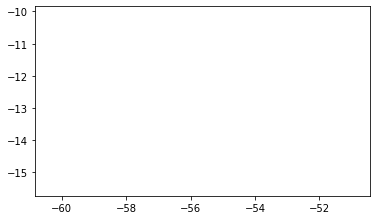

<AxesSubplot:>

In [19]:
# Visualizing LUC ROI:

show(luc_open, transform=luc_open.transform, cmap='viridis')

In [22]:
# Reading LUC ROI classes

luc_roi = luc_open.read(1)
np.unique(luc_roi)

array([ 0,  3,  4,  9, 11, 12, 15, 24, 30, 33, 39, 41], dtype=uint8)

In [25]:
# Counting pixels in each class
np.unique(luc_roi, return_counts=True)

(array([ 0,  3,  4,  9, 11, 12, 15, 24, 30, 33, 39, 41], dtype=uint8),
 array([842744687,     60583,      1758,        43,       159,       173,
           257633,        36,        31,       181,      1341,     15625]))

In [26]:
unique, counts = np.unique(luc_roi, return_counts=True)